# Lab 4 - Reinforcement Learning

## Read details of the environment & model from a text file
Read: 

- Width, Height
- Noise: probability of not going in the intended direction (then divided by two for two unintentional neighbor directions)
- Immediate rewards of non-goal states
- Terminal (goal) states: their locations and rewards
- Internal Walls: locations

Create the transition matrix (T) and the Rewards matrix according to above details.

"grid1.txt" corresponds to the example in AIMA and the lecture slides. You can double-check various results there.

Python style comments in grid1.txt are just comments, can be ignored/deleted.

Task1 - We ask you to create two more grids (files) of moderate size and with at least one internal wall. And perform the analysis described below on these three grids.

In [59]:
import numpy as np
import time as tm

file1 = open('Lab3_grid3.txt', 'r') 
(W, H) = [t(s) for t,s in zip((int,int),file1.readline().split())]
noise = [t(s) for t,s in zip((float,str),file1.readline().split())][0]
immediate_rewards = [t(s) for t,s in zip((float,str),file1.readline().split())][0]
N = W*H #total number of states
NA = 4 #number of actions
T = np.zeros((N,N,NA)) #state transition probabilities
Directions = np.array(['L','R','U','D'])
Rewards = np.zeros((N,1)) + immediate_rewards #immediate rewards
Terminals = np.zeros((N,1)) #terminal states
Walls = np.zeros((N,1)) #(internal) wall states
prob1 = 1-noise
prob2 = noise/2
while True: 
    line = file1.readline() 
    if not line: 
        break
    if line.find('T') != -1:
        (_,x, y, r) = [t(s) for t,s in zip((str,int,int,float),line.split())]
        Terminals[y*W+x] = 1
        Rewards[y*W+x] = r
    if line.find('W') != -1:
        (_,x, y) = [t(s) for t,s in zip((str,int,int),line.split())]
        Walls[y*W+x] = 1     
file1.close()
for i in range(W):
    for j in range(H):
        if i+1<W and Walls[j*W+i+1]==0: #not wall on the right
            T[j*W+i,j*W+i+1,1] += prob1 
            T[j*W+i,j*W+i+1,2] += prob2
            T[j*W+i,j*W+i+1,3] += prob2
        else:
            T[j*W+i,j*W+i,1] += prob1 
            T[j*W+i,j*W+i,2] += prob2
            T[j*W+i,j*W+i,3] += prob2
        if i-1>=0 and Walls[j*W+i-1]==0: #not wall on the left
            T[j*W+i,j*W+i-1,0] += prob1 
            T[j*W+i,j*W+i-1,2] += prob2
            T[j*W+i,j*W+i-1,3] += prob2
        else:
            T[j*W+i,j*W+i,0] += prob1 
            T[j*W+i,j*W+i,2] += prob2
            T[j*W+i,j*W+i,3] += prob2
        if j+1<H and Walls[(j+1)*W+i]==0: #not wall below
            T[j*W+i,(j+1)*W+i,3] += prob1 
            T[j*W+i,(j+1)*W+i,0] += prob2
            T[j*W+i,(j+1)*W+i,1] += prob2
        else:
            T[j*W+i,j*W+i,3] += prob1 
            T[j*W+i,j*W+i,0] += prob2
            T[j*W+i,j*W+i,1] += prob2       
        if j-1>=0 and Walls[(j-1)*W+i]==0: #not wall above
            T[j*W+i,(j-1)*W+i,2] += prob1 
            T[j*W+i,(j-1)*W+i,0] += prob2
            T[j*W+i,(j-1)*W+i,1] += prob2
        else:
            T[j*W+i,j*W+i,2] += prob1 
            T[j*W+i,j*W+i,0] += prob2
            T[j*W+i,j*W+i,1] += prob2    

In [60]:
import matplotlib.pyplot as plt

def draw_grid(width, height, axis):
    for col in range(width + 1):
        axis.axvline(col, color="black", linewidth=0.6)
    for row in range(height + 1):
        axis.axhline(row, color="black", linewidth=0.6)

def properties(index, Walls, Terminals, Rewards, Values = None, Policy=None ):
    if Walls[index] == 1:
        return "black", ""
    elif Terminals[index] == 1:
        if Rewards[index][0] == 1:
            return "green", "G (1)"
        else:
            return "red", "L (-1)"
    else:
        # Show both value and policy arrow
        # Case 1: No policy or no values → empty cell
        if Policy is None or Values is None:
            return "white", ""
        
        # Case 2: Policy and Values are available
        arrow_map = {0:'←', 1:'→', 2:'↑', 3:'↓'}
        arrow = arrow_map[int(Policy[index])]   # <-- removed [0]
        value_text = f"{Values[index]:.2f}"
        return "white", f"{arrow}\n{value_text}"


def plot_grid(W, H, Terminals, Walls, Rewards, Values = None, Policy = None, title="Environment"):
    fig, axis = plt.subplots(figsize=(0.8 * W, 0.8 * H))
    axis.set_xlim(0, W)
    axis.set_ylim(0, H)
    axis.invert_yaxis()
    draw_grid(W, H, axis)

    for row in range(H):
        for col in range(W):
            cell_index = row * W + col
            cell_color, cell_text = properties(cell_index, Walls, Terminals, Rewards, Values, Policy)
            axis.add_patch(plt.Rectangle((col, row), 1, 1, color = cell_color, ec = "black"))
            if cell_text:
                axis.text(col + 0.5, row + 0.5, cell_text, ha="center", va="center", fontsize=10, color="black")

    plt.title(title)
    plt.show()

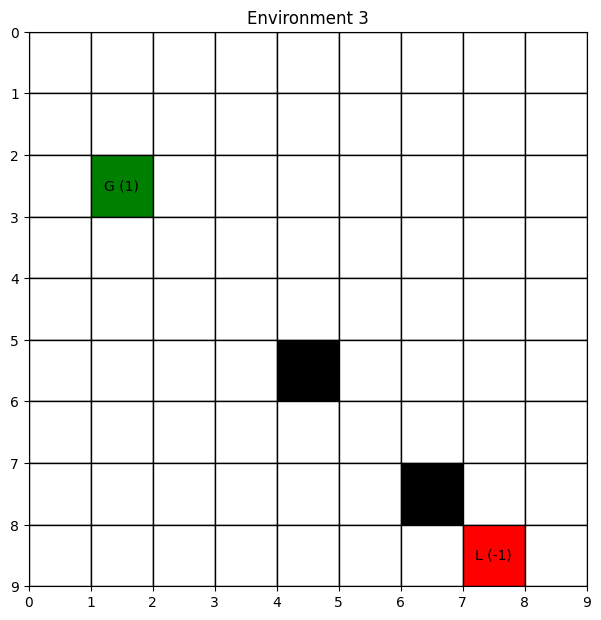

In [61]:
plot_grid(W, H, Terminals, Walls, Rewards, title="Environment 3")

## Task 2 - Implement functions

### Value and Policy iteration
Value iteration is provided, implement policy iteration

### TD-Learning and Q-Learning
Q-Learning is implemented, implement TD-Learning

In [51]:
def value_iteration(gamma, T, Rewards, Terminals, Walls):   
    start_time  = tm.time()
    iteration_cnt = 0 

    N, NA = T.shape[0], T.shape[2]
    V = np.zeros((N,1))
    Policy = np.zeros((N,1))
    while True:
        V_old = np.copy(V)
        iteration_cnt +=1
        
        for s in range(N):
            if Walls[s]==1: continue 
            if Terminals[s]==1:
                V[s] = Rewards[s]
                continue
            Q = np.zeros((NA,1))
            for a in range(NA):
                Q[a] = Rewards[s] + gamma*np.dot(T[s,:,a],V)
            V[s] = np.max(Q)
            Policy[s] = np.argmax(Q)
        if np.sum(np.abs(V-V_old))<1e-10:
            end_time = tm.time()
            break

    tot = end_time - start_time 
    print(f'Value iteration completion time: {abs(tot):.4f} seconds and iteration count is: {iteration_cnt} iterations')
    return V, Policy

def policy_iteration(gamma, T, Rewards, Terminals, Walls): 

    start_time  = tm.time()
    iteration_cnt = 0 

    N, NA = T.shape[0], T.shape[2]
    V = np.zeros((N,1))
    Policy = np.zeros((N,1))    
    
    #-------- PI Implimentation ----------
    def policy_evaluate(Policy):
        while True:
            Delta = 0
            V_old = np.copy(V)
            s = 0 
            for s in range(N):
                if Walls[s] == 1:
                    continue
                if Terminals[s] == 1:
                    V[s] = Rewards[s]
                    continue
                V[s] = Rewards[s] + gamma * np.dot(T[s, :, int(Policy[s][0])], V)
                y = (Delta, np.abs(V_old[s] - V[s]))
                Delta = max(y)
            if Delta < 1e-1:
                break
        return V
    
    def policy_improvment(V):
        for s in range(N):
            if Walls[s] == 1:
                continue

            if Terminals[s] == 1:
                continue

            Q = np.zeros((NA, 1))
            a = 0
            while a < NA:
                Q[a] = Rewards[s] + gamma * np.dot(T[s, :, a], V)
                a += 1
            Policy[s] = np.argmax(Q)
        return Policy
    
    while True:
        old_policy = np.copy(Policy)
        V = policy_evaluate(Policy)
        Policy = policy_improvment(V)
        iteration_cnt +=1
        flag = True

        for s in range(N):
            if old_policy[s] != Policy[s]:
                flag = False
                break
        if flag:
            end_time = tm.time()
            break

    tot = end_time - start_time 
    print(f'Policy iteration completion time: {abs(tot):.4f} seconds and iteration count is: {iteration_cnt} iterations')
    return V, Policy

def TD_learning(N_episodes, alpha, gamma, T, Rewards, Terminals, Walls): 
    start_time = tm.time()

    N, NA = T.shape[0], T.shape[2]
    V = np.zeros((N,1))
    Policy = np.zeros((N,1)) 

    #---------------- TD Implimentaion -----------------------------
    for ep in range(N_episodes):
        s = int(np.floor(np.random.uniform(0, N-1)))

        while Terminals[s]==1 or Walls[s]==1:
            s = int(np.floor(np.random.uniform(0,N-1)))

        while Terminals[s] == 0:
            a = int(np.floor(np.random.uniform(0, NA)))
            u = np.random.uniform(0, 1) 
            s1 = np.argmax(u < np.cumsum(T[s,:,a])) #next state
            target = Rewards[s1] + gamma* V[s1]
            error = target - V[s]
            delta = alpha*error
            V[s] += delta
            s = s1     
        alpha *= 0.999 #optimal learning-rate decay 

    # deriving policy from value function \
    for s in range(N):
        if Walls[s] == 1 or Terminals[s] == 1:
            continue
        action_values = np.zeros(NA)
        for a in range(NA):
            action_values[a] = np.sum(T[s, :, a] * V[:, 0])
        Policy[s] = np.argmax(action_values)
    
    end_time = tm.time()
    tot = end_time - start_time 
    print(f'TD learning completion time: {abs(tot):.4f} seconds')

    return V, Policy

def Q_learning(N_episodes, epsilon, alpha, gamma, T, Rewards, Terminals, Walls): 
    start_time = tm.time()
    N, NA = T.shape[0], T.shape[2]
    Q = np.zeros((N,NA))
    for e in range(N_episodes):
        s = int(np.floor(np.random.uniform(0,N-1)))
        while Terminals[s]==1 or Walls[s]==1:
            s = int(np.floor(np.random.uniform(0,N-1)))
        while Terminals[s]==0:
            u = np.random.uniform(0,1)
            if u<epsilon:
                a = int(np.floor(np.random.uniform(0,NA)))
            else:
                a = np.argmax(Q[s,:])
            u = np.random.uniform(0,1)
            s1 = np.argmax(u<np.cumsum(T[s,:,a]))
            Q[s,a] += alpha*(Rewards[s1][0] + gamma*np.max(Q[s1,:]) - Q[s,a])
            s = s1
        epsilon = epsilon*0.9999 # Modify here for other annealing regimes
        alpha = alpha*0.9999 # Modify here for other annealing regimes
    V = np.max(Q,axis=1)
    V = V[:,None]
    V[Terminals==1] = Rewards[Terminals==1] 
    Policy = np.array(np.argmax(Q,axis=1)).reshape((N,1))

    end_time = tm.time()
    tot = end_time - start_time 
    print(f' learning completion time: {abs(tot):.4f} seconds')

    return V, Policy

## Task 3 - Experiments

For the three grids you have, perform the following analysis and include them in your report,.

- Compare value and policy iterations in terms of convergence time. Relate it to computational complexity, current implementation and number of iterations needed.

- How are optimal policies change with immediate reward values? Show some examples (similar to Figure 17.2b in AIMA)

- Compare TD-Learning and Q-Learning results with each other. Also with value and policy iterations. Remember that value and policy iteration solve Markov Decision Processes where we know the model (T and Rewards). TD-Learning and Q-Learning are (passive and active, respectively) Reinforcement Learning methods that don't have the model but use data from simulations. Data are simulated from the model we know, but the model is not used n TD or Q-Learning.

- What are the effects of epsilon and alpha values and how they are modified?

- What is the effect of number of episodes?

Value iteration completion time: 0.0301 seconds and iteration count is: 28 iterations
Policy iteration completion time: 0.0130 seconds and iteration count is: 6 iterations
[[ 0.84822914  0.87919854  0.83775972  0.79329701  0.74813294  0.70233307
   0.65596369  0.60908827  0.56176567]
 [ 0.89435797  0.93824957  0.88813771  0.83759533  0.78682038  0.73593408
   0.68500864  0.63408498  0.58318482]
 [ 0.93887152  1.          0.93762082  0.8775546   0.81930821  0.7624447
   0.70665008  0.65169238  0.59740271]
 [ 0.89435721  0.93824277  0.88807047  0.83698414  0.7858249   0.73404721
   0.68193457  0.62963818  0.57730327]
 [ 0.84822091  0.87913048  0.83714172  0.78772302  0.74306767  0.69142824
   0.6403179   0.58921292  0.53852448]
 [ 0.80086452  0.82201343  0.78622595  0.74311223  0.          0.63569382
   0.58981848  0.53994784  0.49423819]
 [ 0.75258472  0.76634633  0.7347711   0.69155714  0.63590246  0.58654739
   0.5424664   0.49171763  0.44951368]
 [ 0.70360226  0.71174258  0.68305289 

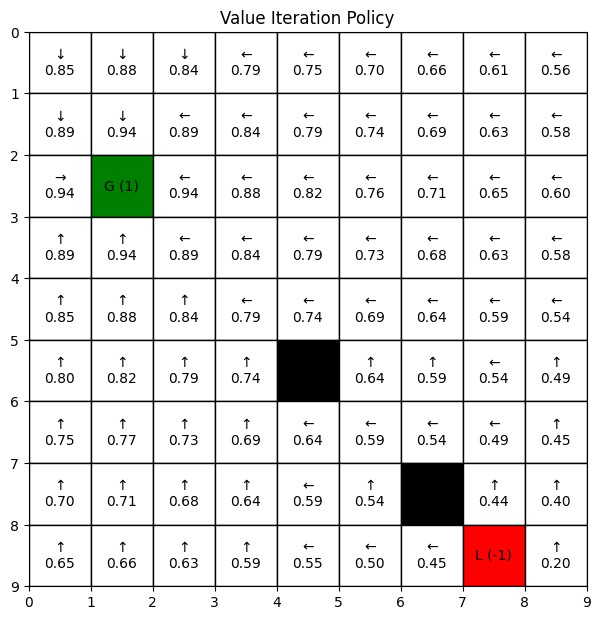

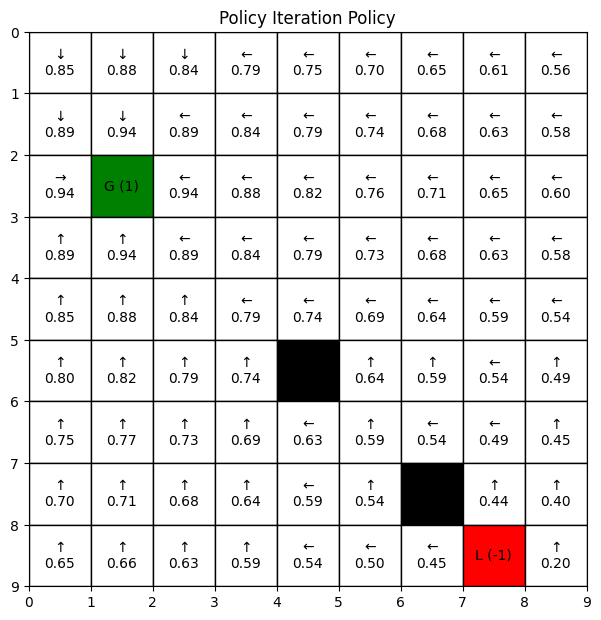

In [52]:
gamma = 1
alpha = 0.9
epsilon = 0.5
N_episodes = 20000

#Value iteration
V_VI, Policy_VI = value_iteration(gamma, T, Rewards, Terminals, Walls)
#Policy iteration
V_PI, Policy_PI = policy_iteration(gamma, T, Rewards, Terminals, Walls)


print(V_VI.reshape((H,W)))
maze = Directions[Policy_VI.astype(int)]
maze[Walls==1] = 'W'
maze[Terminals==1] = 'G'
print(maze.reshape((H,W)))

print(V_PI.reshape((H,W)))
maze = Directions[Policy_PI.astype(int)]
maze[Walls==1] = 'W'
maze[Terminals==1] = 'G'
print(maze.reshape((H,W)))

V_VI_flat = V_VI.flatten()
V_PI_flat = V_PI.flatten()
Policy_VI_flat = Policy_VI.flatten()
Policy_PI_flat = Policy_PI.flatten()

plot_grid(W, H, Terminals, Walls, Rewards, V_VI_flat, Policy_VI_flat, "Value Iteration Policy")
plot_grid(W, H, Terminals, Walls, Rewards, V_PI_flat, Policy_PI_flat, "Policy Iteration Policy")


TD learning completion time: 20.2245 seconds
 learning completion time: 2.4833 seconds
[[-1.22618042 -1.40463883 -2.08605533 -2.85741626 -3.52466458 -4.05739954
  -4.46453048 -4.72074413 -4.84565222]
 [-0.88347564 -0.80701435 -1.83530095 -2.77979881 -3.50378079 -4.04222295
  -4.43708865 -4.68982832 -4.8080569 ]
 [-0.53546147  0.         -1.53875593 -2.77083225 -3.53558491 -4.04767185
  -4.41146296 -4.62788297 -4.72677311]
 [-1.52242747 -1.38835333 -2.27256258 -3.06918494 -3.66315596 -4.08217433
  -4.36665993 -4.5176828  -4.58209835]
 [-2.51430161 -2.57764668 -2.98208802 -3.41219741 -3.79152487 -4.11755749
  -4.27994527 -4.33461601 -4.35376023]
 [-3.25739008 -3.32989735 -3.5041581  -3.67620918  0.         -4.15357882
  -4.1362291  -4.02155726 -3.9807262 ]
 [-3.77061978 -3.81619751 -3.88769401 -3.9645564  -4.05370983 -4.03920428
  -3.93845518 -3.46987597 -3.40539178]
 [-4.08316418 -4.09462026 -4.10313029 -4.08201462 -4.00434414 -3.85000836
   0.         -2.35954387 -2.57160769]
 [-4.2334

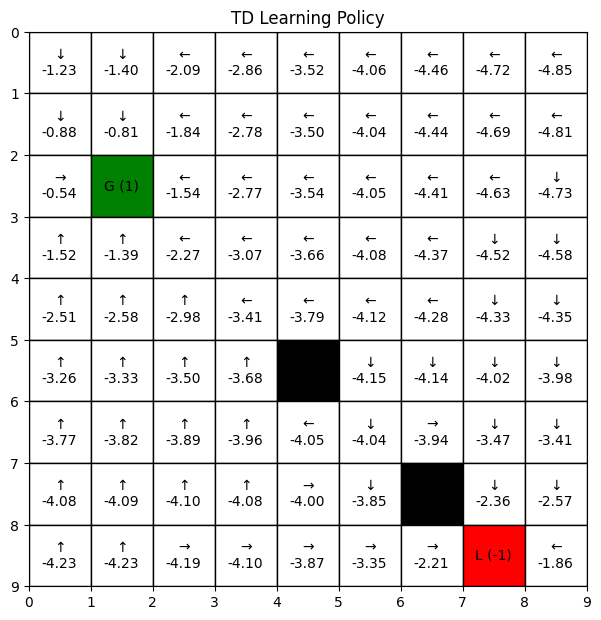

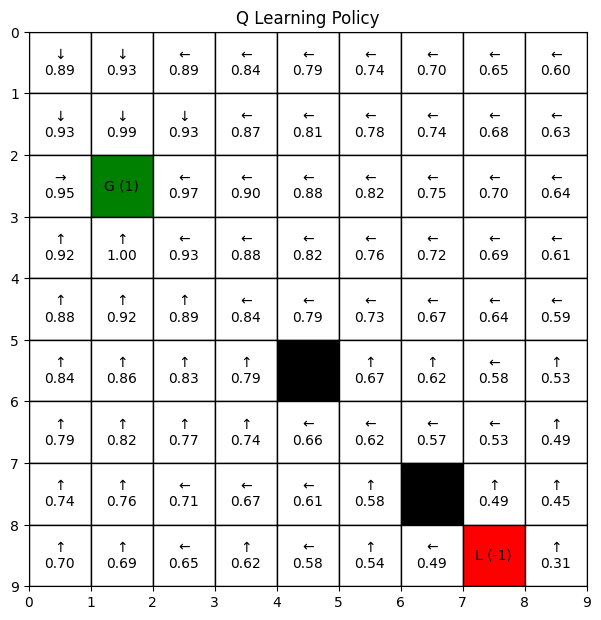

In [53]:
#TD-Learning
V_TD, Policy_TD = TD_learning(N_episodes, alpha, gamma, T, Rewards, Terminals, Walls)
#Q-Learning
V_Q, Policy_Q = Q_learning(N_episodes, epsilon, alpha, gamma, T, Rewards, Terminals, Walls)

print(V_TD.reshape((H,W)))
maze_TD = Directions[Policy_TD.astype(int)]
maze_TD[Walls==1] = 'W'
maze_TD[Terminals==1] = 'G'
print(maze_TD.reshape((H,W)))

print(V_Q.reshape((H,W)))
maze_Q = Directions[Policy_Q.astype(int)]
maze_Q[Walls==1] = 'W'
maze_Q[Terminals==1] = 'G'
print(maze_Q.reshape((H,W)))

V_TD_flat = V_TD.flatten()
V_Q_flat = V_Q.flatten()
Policy_TD_flat = Policy_TD.flatten()
Policy_Q_flat = Policy_Q.flatten()

plot_grid(W, H, Terminals, Walls, Rewards, V_TD_flat, Policy_TD_flat, "TD Learning Policy")
plot_grid(W, H, Terminals, Walls, Rewards, V_Q_flat, Policy_Q_flat, "Q Learning Policy")

## Task 4 (extra credit) - What if diagonal moves were possible?

Repeat the experiments in one of these settings. You don't have to stick to the code provided here. But, you can only use Numpy (and matplotlib).

You should decide on how to distribute the noise associated with actions across (next) states. For example, in the scenario above we have probability of going Up with the Up action is 1-noise. The probability of going Left with the Up action is noise/2. The same for going Right.

In [54]:
file1 = open('Lab3_grid3.txt', 'r') 
(W, H) = [t(s) for t,s in zip((int,int),file1.readline().split())]
noise = [t(s) for t,s in zip((float,str),file1.readline().split())][0]
immediate_rewards = [t(s) for t,s in zip((float,str),file1.readline().split())][0]

N = W*H #total number of states

# ---------------- Task 4 change ----------------
NA = 8 # number of actions (4 cardinal + 4 diagonal)
Directions = np.array(['L','R','U','D','UL','UR','DL','DR'])
# ----------------------------------------------

T = np.zeros((N,N,NA)) #state transition probabilities
Rewards = np.zeros((N,1)) + immediate_rewards #immediate rewards
Terminals = np.zeros((N,1)) #terminal states
Walls = np.zeros((N,1)) #(internal) wall states

prob1 = 1-noise
prob2 = noise/2

while True: 
    line = file1.readline() 
    if not line: 
        break
    if line.find('T') != -1:
        (_,x, y, r) = [t(s) for t,s in zip((str,int,int,float),line.split())]
        Terminals[y*W+x] = 1
        Rewards[y*W+x] = r
    if line.find('W') != -1:
        (_,x, y) = [t(s) for t,s in zip((str,int,int),line.split())]
        Walls[y*W+x] = 1     
file1.close()

for i in range(W):
    for j in range(H):

        # ---------------- Existing 4-action transitions (UNCHANGED) ----------------

        if i+1<W and Walls[j*W+i+1]==0: #not wall on the right
            T[j*W+i,j*W+i+1,1] += prob1 
            T[j*W+i,j*W+i+1,2] += prob2
            T[j*W+i,j*W+i+1,3] += prob2
        else:
            T[j*W+i,j*W+i,1] += prob1 
            T[j*W+i,j*W+i,2] += prob2
            T[j*W+i,j*W+i,3] += prob2

        if i-1>=0 and Walls[j*W+i-1]==0: #not wall on the left
            T[j*W+i,j*W+i-1,0] += prob1 
            T[j*W+i,j*W+i-1,2] += prob2
            T[j*W+i,j*W+i-1,3] += prob2
        else:
            T[j*W+i,j*W+i,0] += prob1 
            T[j*W+i,j*W+i,2] += prob2
            T[j*W+i,j*W+i,3] += prob2

        if j+1<H and Walls[(j+1)*W+i]==0: #not wall below
            T[j*W+i,(j+1)*W+i,3] += prob1 
            T[j*W+i,(j+1)*W+i,0] += prob2
            T[j*W+i,(j+1)*W+i,1] += prob2
        else:
            T[j*W+i,j*W+i,3] += prob1 
            T[j*W+i,j*W+i,0] += prob2
            T[j*W+i,j*W+i,1] += prob2       

        if j-1>=0 and Walls[(j-1)*W+i]==0: #not wall above
            T[j*W+i,(j-1)*W+i,2] += prob1 
            T[j*W+i,(j-1)*W+i,0] += prob2
            T[j*W+i,(j-1)*W+i,1] += prob2
        else:
            T[j*W+i,j*W+i,2] += prob1 
            T[j*W+i,j*W+i,0] += prob2
            T[j*W+i,j*W+i,1] += prob2    

        # ---------------- Task 4: Diagonal actions ----------------
        s = j*W + i

        # UL (action 4): intended UL, noise → U, L
        if j-1>=0 and i-1>=0 and Walls[(j-1)*W + (i-1)]==0:
            T[s,(j-1)*W + (i-1),4] += prob1
        else:
            T[s,s,4] += prob1

        if j-1>=0 and Walls[(j-1)*W + i]==0:
            T[s,(j-1)*W + i,4] += prob2
        else:
            T[s,s,4] += prob2

        if i-1>=0 and Walls[j*W + (i-1)]==0:
            T[s,j*W + (i-1),4] += prob2
        else:
            T[s,s,4] += prob2


        # UR (action 5): intended UR, noise → U, R
        if j-1>=0 and i+1<W and Walls[(j-1)*W + (i+1)]==0:
            T[s,(j-1)*W + (i+1),5] += prob1
        else:
            T[s,s,5] += prob1

        if j-1>=0 and Walls[(j-1)*W + i]==0:
            T[s,(j-1)*W + i,5] += prob2
        else:
            T[s,s,5] += prob2

        if i+1<W and Walls[j*W + (i+1)]==0:
            T[s,j*W + (i+1),5] += prob2
        else:
            T[s,s,5] += prob2


        # DL (action 6): intended DL, noise → D, L
        if j+1<H and i-1>=0 and Walls[(j+1)*W + (i-1)]==0:
            T[s,(j+1)*W + (i-1),6] += prob1
        else:
            T[s,s,6] += prob1

        if j+1<H and Walls[(j+1)*W + i]==0:
            T[s,(j+1)*W + i,6] += prob2
        else:
            T[s,s,6] += prob2

        if i-1>=0 and Walls[j*W + (i-1)]==0:
            T[s,j*W + (i-1),6] += prob2
        else:
            T[s,s,6] += prob2


        # DR (action 7): intended DR, noise → D, R
        if j+1<H and i+1<W and Walls[(j+1)*W + (i+1)]==0:
            T[s,(j+1)*W + (i+1),7] += prob1
        else:
            T[s,s,7] += prob1

        if j+1<H and Walls[(j+1)*W + i]==0:
            T[s,(j+1)*W + i,7] += prob2
        else:
            T[s,s,7] += prob2

        if i+1<W and Walls[j*W + (i+1)]==0:
            T[s,j*W + (i+1),7] += prob2
        else:
            T[s,s,7] += prob2


In [55]:
def draw_grid(width, height, axis):
    for col in range(width + 1):
        axis.axvline(col, color="black", linewidth=0.6)
    for row in range(height + 1):
        axis.axhline(row, color="black", linewidth=0.6)

def properties(index, Walls, Terminals, Rewards, Values, Policy):
    if Walls[index] == 1:
        return "black", ""
    elif Terminals[index] == 1:
        return ("green","G (1)") if Rewards[index] == 1 else ("red","L (-1)")
    else:
        arrow_map = {
            0:'←', 1:'→', 2:'↑', 3:'↓',
            4:'↖', 5:'↗', 6:'↙', 7:'↘'
        }
        arrow = arrow_map[int(Policy[index])]
        return "white", f"{arrow}\n{Values[index]:.2f}"

def plot_grid(W, H, Terminals, Walls, Rewards, Values, Policy, title):
    fig, axis = plt.subplots(figsize=(0.8*W,0.8*H))
    axis.set_xlim(0,W)
    axis.set_ylim(0,H)
    axis.invert_yaxis()
    draw_grid(W,H,axis)

    for r in range(H):
        for c in range(W):
            i = r*W + c
            col, txt = properties(i,Walls,Terminals,Rewards,Values,Policy)
            axis.add_patch(plt.Rectangle((c,r),1,1,color=col,ec="black"))
            if txt:
                axis.text(c+0.5,r+0.5,txt,ha="center",va="center")

    plt.title(title)
    plt.show()


Value iteration completion time: 0.0255 seconds and iteration count is: 14 iterations
Policy iteration completion time: 0.0316 seconds and iteration count is: 14 iterations
[[ 0.90555556  0.90555556  0.90555556  0.90111111  0.86066667  0.81662222
   0.77221778  0.72777733  0.68333329]
 [ 0.95        0.95        0.95        0.90555556  0.86111111  0.81666667
   0.77222222  0.72777778  0.68333333]
 [ 0.95        1.          0.95        0.90555556  0.86111111  0.81666667
   0.77222222  0.72777778  0.68333333]
 [ 0.95        0.95        0.95        0.90555556  0.86111111  0.81666667
   0.77222222  0.72777778  0.68333333]
 [ 0.90555556  0.90555556  0.90555556  0.90111111  0.86066667  0.81662222
   0.77221778  0.72777733  0.68333329]
 [ 0.86111111  0.86111111  0.86111111  0.86066667  0.          0.8113284
   0.7716524   0.7277172   0.68332692]
 [ 0.81666667  0.81666667  0.81666667  0.81662222  0.8113284   0.76648318
   0.76287627  0.72638126  0.68314457]
 [ 0.77222222  0.77222222  0.77222222

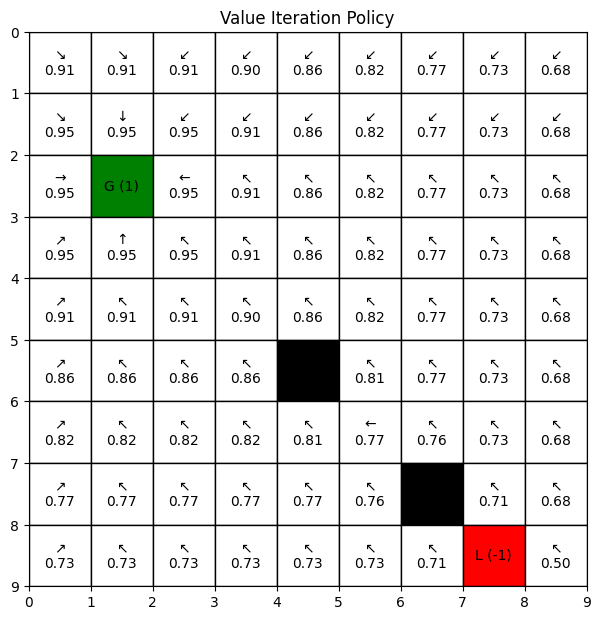

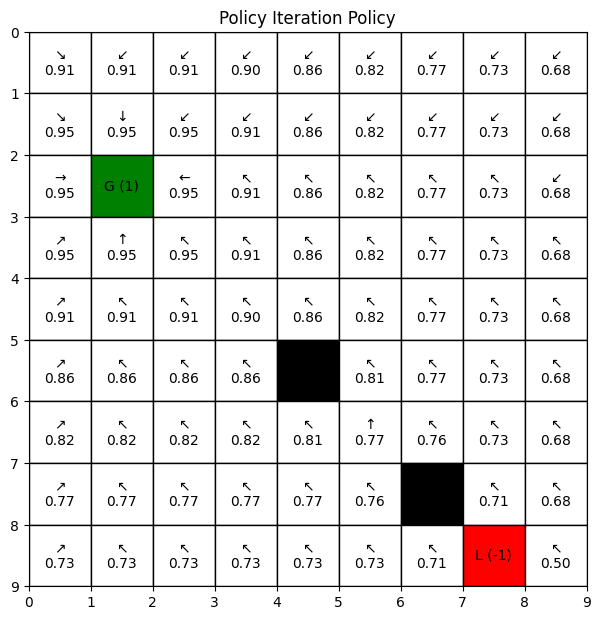

In [56]:
gamma = 1
alpha = 0.9
epsilon = 0.5
N_episodes = 20000

#Value iteration
V_VI, Policy_VI = value_iteration(gamma, T, Rewards, Terminals, Walls)
#Policy iteration
V_PI, Policy_PI = policy_iteration(gamma, T, Rewards, Terminals, Walls)


print(V_VI.reshape((H,W)))
maze = Directions[Policy_VI.astype(int)]
maze[Walls==1] = 'W'
maze[Terminals==1] = 'G'
print(maze.reshape((H,W)))

print(V_PI.reshape((H,W)))
maze = Directions[Policy_PI.astype(int)]
maze[Walls==1] = 'W'
maze[Terminals==1] = 'G'
print(maze.reshape((H,W)))

V_VI_flat = V_VI.flatten()
V_PI_flat = V_PI.flatten()
Policy_VI_flat = Policy_VI.flatten()
Policy_PI_flat = Policy_PI.flatten()

plot_grid(W, H, Terminals, Walls, Rewards, V_VI_flat, Policy_VI_flat, "Value Iteration Policy")
plot_grid(W, H, Terminals, Walls, Rewards, V_PI_flat, Policy_PI_flat, "Policy Iteration Policy")
